# Apr ??, 2022 ()

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Check data is loaded

In [2]:
mice = Mice(128)

In [3]:
mice.setup_anat_data()
mice.setup_preproc_data()

In [4]:
len(mice.T1w), len(mice.ref), len(mice.mask2d), len(mice.mask3d)

(30, 30, 30, 30)

In [5]:
save_dir = pjoin(fig_dir, 'quality_control')
os.makedirs(save_dir, exist_ok=True)

save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control'

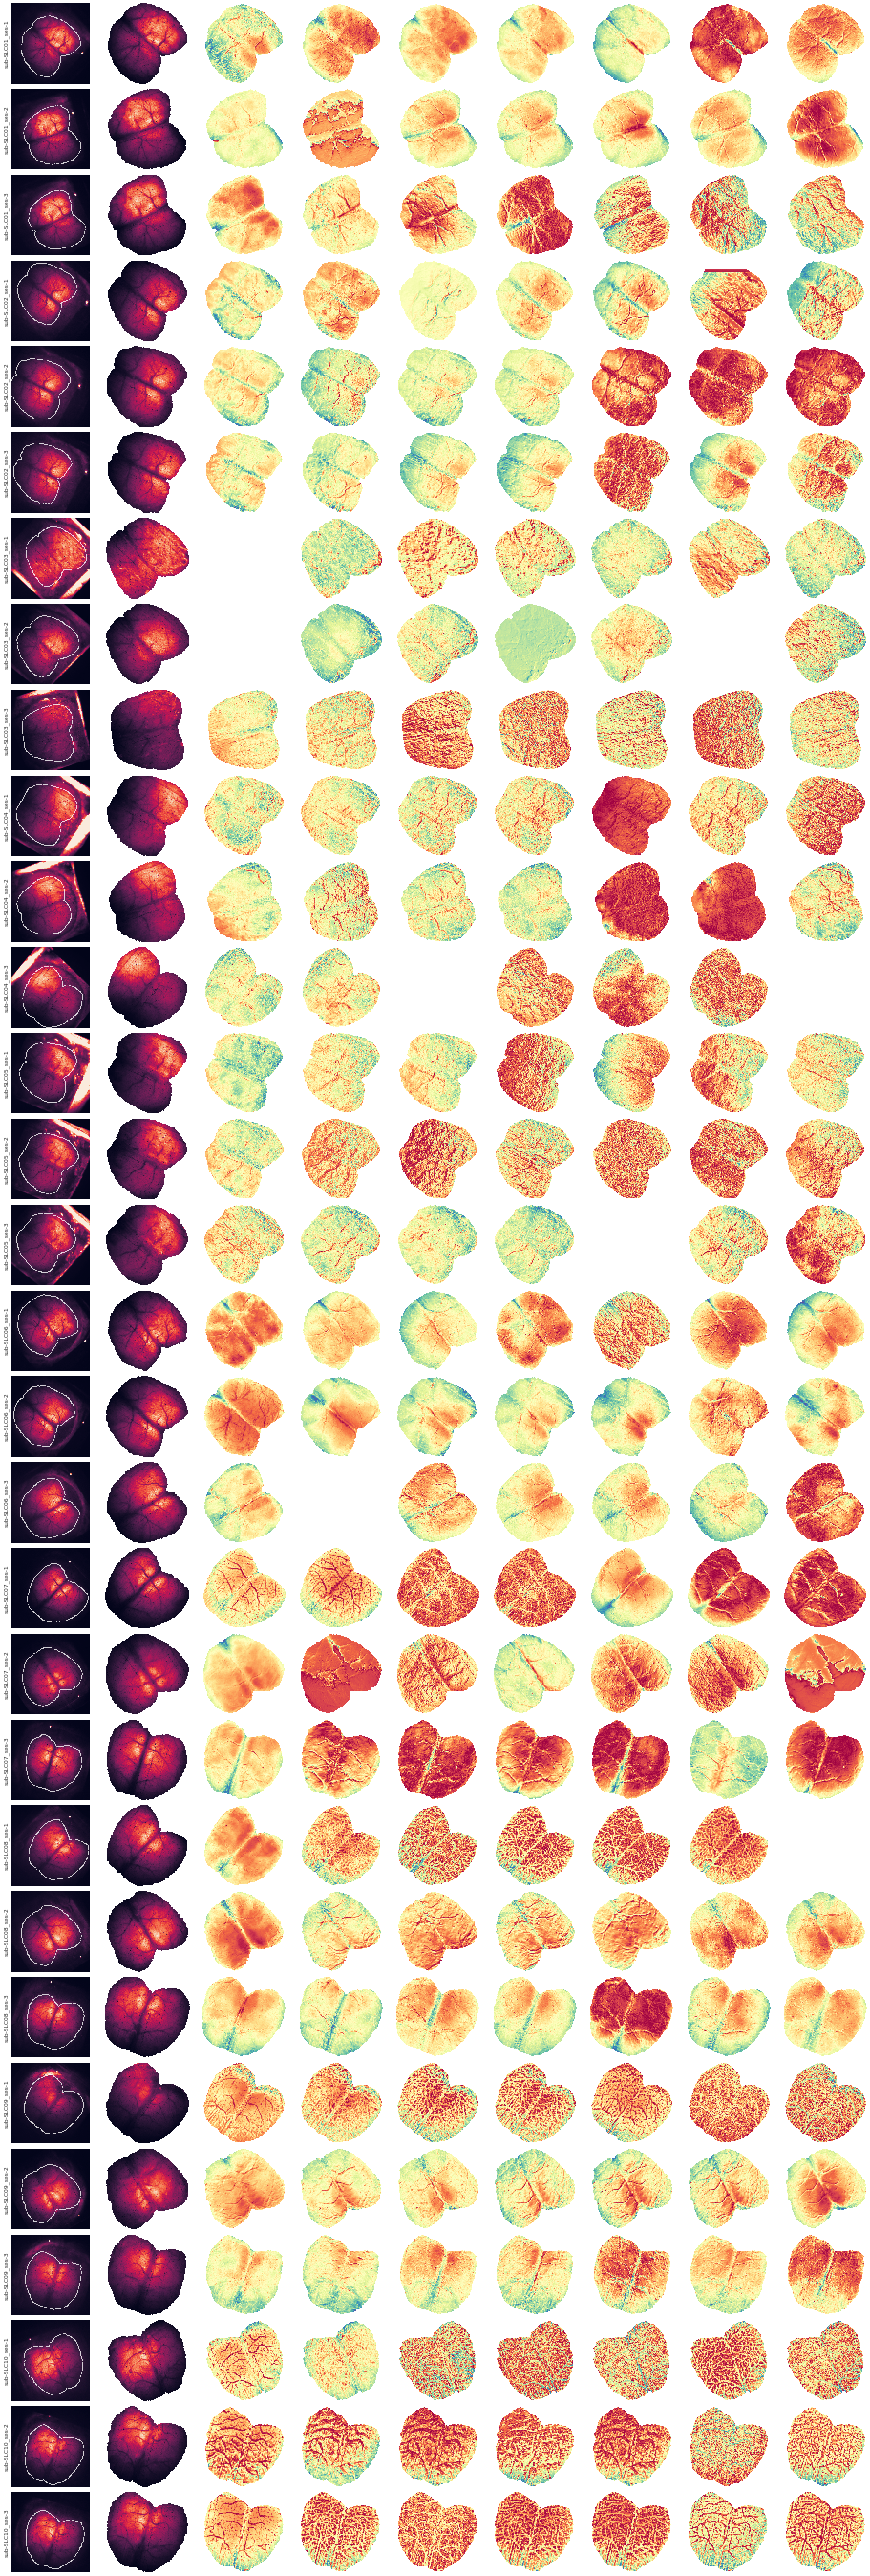

In [6]:
nrows = len(mice.ref)
fig, axes = create_figure(nrows, 9, (26, 2.5 * nrows), dpi=36)

tstart = 1000
for i, (k, anat) in enumerate(mice.ref.items()):
    axes[i, 0].set_ylabel(k, fontsize=12)
    
    m = mice.mask2d[k].load_ants().numpy().squeeze().astype(bool)
    ref = anat.load_ants().numpy().squeeze().astype(float)
    ref = sp_img.zoom(ref, 0.5)
    
    tsnr = []
    for run in mice.cfg.run_ids:
        key = mice.get_key(*mice.looper[k][:-1], run)
        x = mice.ca_preproc[key].load_ants()
        if x is not None:
            x = x.numpy().squeeze()
            tsnr.append(np.abs(x[..., tstart:].mean(-1)) / x[..., tstart:].std(-1))
        else:
            tsnr.append(np_nans(m.shape))
    
    contour = np.logical_or(
        sp_img.sobel(m, axis=0),
        sp_img.sobel(m, axis=1),
    )
    ax = axes[i, 0]
    ax.imshow(ref, vmax=np.max(ref * m))
    x2p = mwh(contour == 0, contour)
    ax.imshow(x2p, cmap='Greys', alpha=0.8)
    
    filtered = filter_boundaries([ref, m] + tsnr, m)
    ref, m = filtered[:2]
    tsnr = filtered[2:]
    
    ax = axes[i, 1]
    x2p = mwh(m == 0, ref)
    ax.imshow(x2p)
    
    for j, x in enumerate(tsnr, start=2):
        ax = axes[i, j]
        x2p = mwh(m == 0, x)
        ax.imshow(x2p, cmap='Spectral')

remove_ticks(axes)
fig.savefig(pjoin(save_dir, 'Ref_vs_masks.pdf'), bbox_inches='tight')
plt.show()

## Temporal masks
Is it mostly first 50 seconds?  No, it's all over the place.

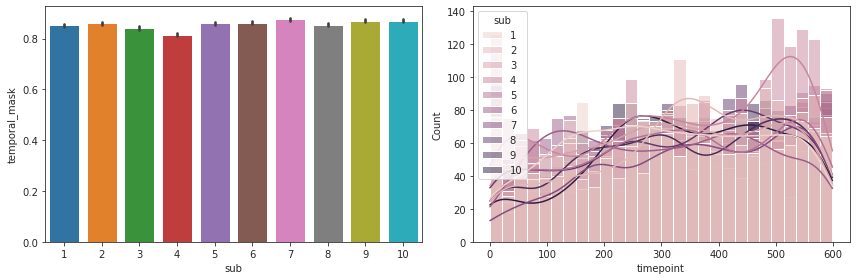

In [44]:
df = pd.read_pickle(pjoin(mice.cfg.base_dir, 'meta_info', 'temporal_mask.df'))

fig, axes = create_figure(1, 2, figsize=(12, 4))
sns.barplot(data=df, x='sub', y='temporal_mask', ax=axes[0])
_df = df.loc[df['temporal_mask'] == 0]
sns.histplot(data=_df, x='timepoint', kde=True, hue='sub', ax=axes[1])

plt.show()

## Plot of all normalized ca GSR 

In [ ]:
gs_ca, gs_bold = {}, {}
for k, (sub, ses, run) in tqdm(mice.looper.items()):
    if run == -1:
        continue
    m = mice.mask2d[mice.get_key(sub, ses)]
    m = m.load_ants().numpy().squeeze().astype(bool)
    x = mice.ca_preproc[k].load_ants()
    gs = np_nans(6000)
    if x is not None:
        x = x.numpy().squeeze()
        gs = x[m].mean(0)
    gs_ca[k] = gs
    
    m = mice.mask3d[mice.get_key(sub, ses)]
    m = m.load_ants().numpy().squeeze().astype(bool)
    x = mice.bold_preproc[k].load_ants()
    tmask = df.loc[
        (df['sub'] == sub) &
        (df['ses'] == ses) &
        (df['run'] == run),
        'temporal_mask',
    ].values.astype(bool)
    gs = np_nans(600)
    if x is not None:
        x = x.numpy().squeeze()
        gs[tmask] = x[m].mean(0)
    gs_bold[k] = gs

  0%|          | 0/254 [00:00<?, ?it/s]

In [ ]:
#fig, axes = create_figure()

#tstart = 1000
for k, (sub, ses, run) in mice.looper.items():
    if run == -1:
        continue
    m = mice.mask2d[mice.get_key(sub, ses)]
    m = m.load_ants().numpy().squeeze()
    x = mice.ca_preproc[k].load_ants()
    if x is not None:
        x = x.numpy().squeeze()
        x = x[m].mean(0, keepdims=True)
        # x = ner.fit_transform(x).ravel()
        
        
    bold = mice.bold_preproc[k].load_ants()

In [ ]:
sns.choos